__Source Problems__

In the previous chapter, we investigated two pixelizations; Rectanguar and VoronoiMagnification. We learnt that the latter was better than the former, because it dedicated more source-pixels to the regions of the source-plane where we had more data, e.g, the high-magnification regions. Therefore, we could fit the data using fewer source pixels, which was great for computational efficiency and increasing the Bayesian evidence of our fits.

However, this pixelization is still far from optimal. To understand why, lets inspect fits to three strong lenses, simulated using the same mass profile but with different source light profiles, where each source becomes gradually  more compact. For all 3 fits, we'll use the same source-plane resolution, and regularization coefficient that maximize the Bayesian evidence. Thus, these are the 'best' source reconstructions we can hope to achieve when adapting to the magnification.

In [ ]:
%matplotlib inline

from autolens.data import ccd
from autolens.data import simulated_ccd
from autolens.data.array import mask as msk
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.lens import lens_fit
from autolens.lens import lens_data as ld
from autolens.model.inversion import pixelizations as pix
from autolens.model.inversion import regularization as reg
from autolens.model.inversion.plotters import inversion_plotters
from autolens.lens.plotters import lens_fit_plotters

We'll use 3 sources, where the only difference between each one is that their effective radius and Sersic index are changed such tht each is more compact that the last.

In [ ]:
source_galaxy_flat = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.0, 0.0),
        axis_ratio=0.7,
        phi=135.0,
        intensity=0.2,
        effective_radius=0.5,
        sersic_index=1.0,
    ),
)

source_galaxy_compact = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.0, 0.0),
        axis_ratio=0.7,
        phi=135.0,
        intensity=0.2,
        effective_radius=0.2,
        sersic_index=2.5,
    ),
)

source_galaxy_super_compact = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.0, 0.0),
        axis_ratio=0.7,
        phi=135.0,
        intensity=0.2,
        effective_radius=0.1,
        sersic_index=4.0,
    ),
)

The function below uses each source galaxy to simulate ccd data. It performs the usual tasks we are used to seeing (make the PSF, galaxies, tracer, etc.). 

In [ ]:
def simulate_for_source_galaxy(source_galaxy):

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.from_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
        shape=(150, 150), pixel_scale=0.05, sub_grid_size=2
    )

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.6
        ),
    )

    tracer = ray_tracing.TracerImageSourcePlanes(
        lens_galaxies=[lens_galaxy],
        source_galaxies=[source_galaxy],
        image_plane_grid_stack=image_plane_grid_stack,
    )

    return simulated_ccd.SimulatedCCDData.from_tracer_and_exposure_arrays(
        tracer=tracer,
        pixel_scale=0.05,
        exposure_time=300.0,
        psf=psf,
        background_sky_level=1.0,
        add_noise=True,
        noise_seed=1,
    )

We'll use the same 2.5" mask to fit all three of our sources.

In [ ]:
mask = msk.Mask.circular(shape=(150, 150), pixel_scale=0.05, radius_arcsec=3.0)

Now, lets simulate all 3 of our source's as CCD imaging data.

In [ ]:
ccd_data_source_flat = simulate_for_source_galaxy(source_galaxy=source_galaxy_flat)

ccd_data_source_compact = simulate_for_source_galaxy(
    source_galaxy=source_galaxy_compact
)

ccd_data_source_super_compact = simulate_for_source_galaxy(
    source_galaxy=source_galaxy_super_compact
)

We'll make one more useful function, which fits each simulated ccd_data set with a VoronoiMagniication pixelization.

We'll input the regularization coefficient of each fit, so that for each simulated source we can regularize it at an appropriate level. Again, there nothing new in this function you haven't seen before.

In [ ]:
def fit_ccd_data_with_voronoi_magnification_pixelization(
    ccd_data, mask, regularization_coefficient
):

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.6
        ),
    )

    lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)

    source_galaxy = g.Galaxy(
        redshift=1.0,
        pixelization=pix.VoronoiMagnification(shape=(30, 30)),
        regularization=reg.Constant(coefficient=regularization_coefficient),
    )

    pixelization_grid = source_galaxy.pixelization.pixelization_grid_from_grid_stack(
        grid_stack=lens_data.grid_stack
    )

    grid_stack_with_pixelization_grid = lens_data.grid_stack.new_grid_stack_with_grids_added(
        pixelization=pixelization_grid
    )

    tracer = ray_tracing.TracerImageSourcePlanes(
        lens_galaxies=[lens_galaxy],
        source_galaxies=[source_galaxy],
        image_plane_grid_stack=grid_stack_with_pixelization_grid,
        border=lens_data.border,
    )

    return lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

Lets fit our first source, which has the flattest light profile.

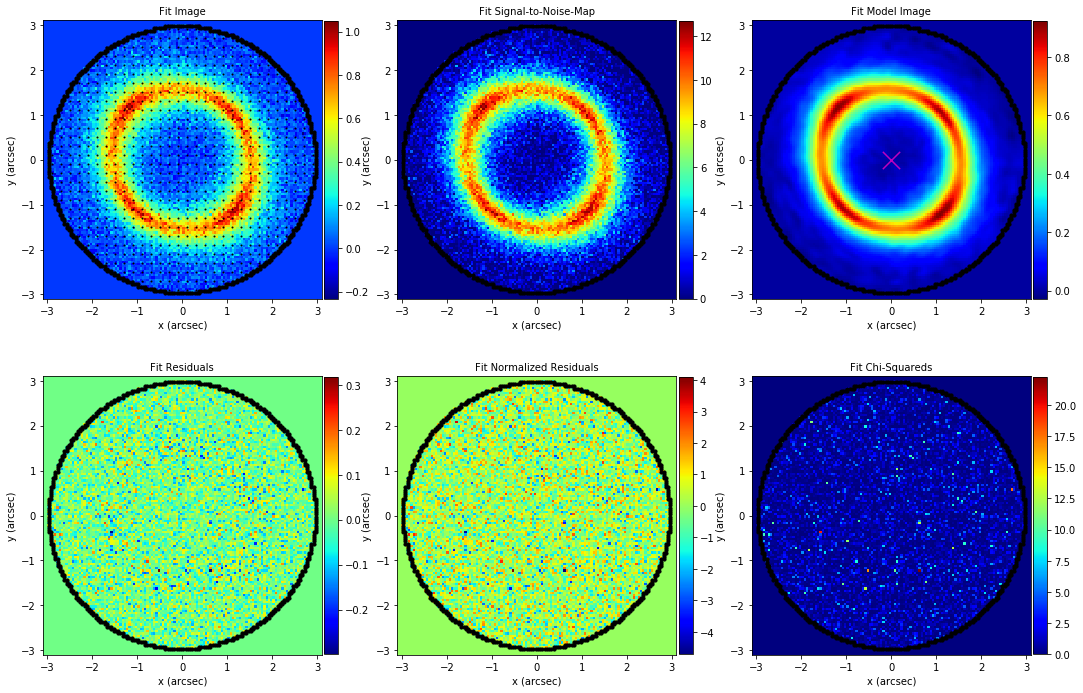

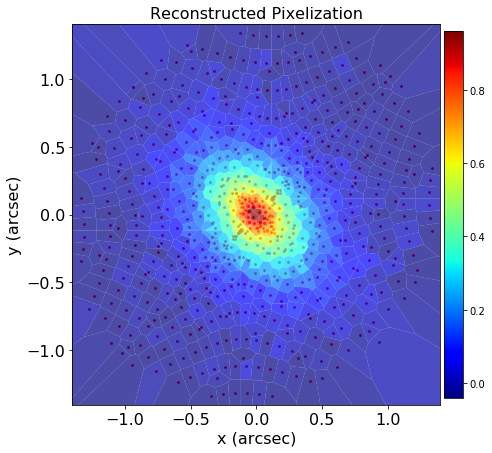

14813.656783059096


In [ ]:
fit_flat = fit_ccd_data_with_voronoi_magnification_pixelization(
    ccd_data=ccd_data_source_flat, mask=mask, regularization_coefficient=9.2
)

lens_fit_plotters.plot_fit_subplot(
    fit=fit_flat,
    should_plot_image_plane_pix=True,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

inversion_plotters.plot_pixelization_values(
    inversion=fit_flat.inversion, should_plot_centres=True
)

print(fit_flat.evidence)

Okay, so the fit was *excellent*. There were efffectively no residuals in the fit, and the source has been reconstructed using lots of pixels! Nice!

Now, lets fit the next source, which is more compact.

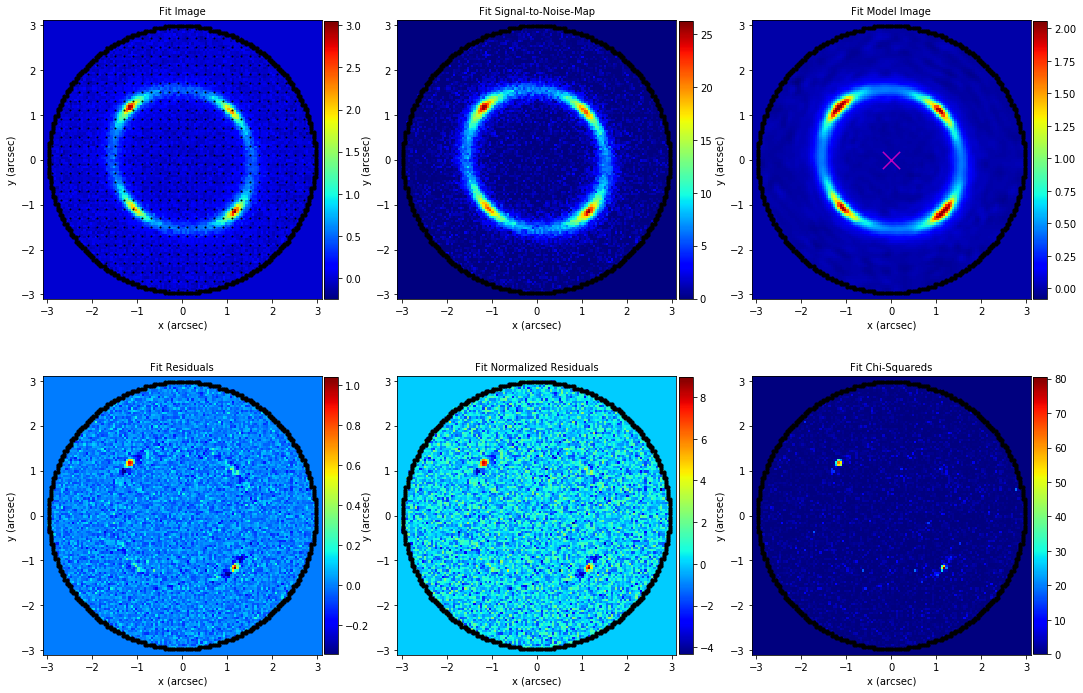

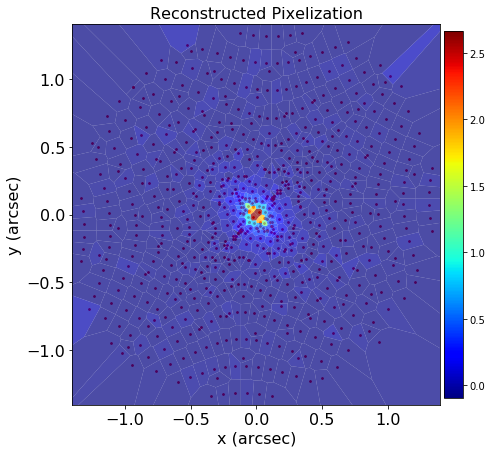

14236.292117135737


In [ ]:
fit_compact = fit_ccd_data_with_voronoi_magnification_pixelization(
    ccd_data=ccd_data_source_compact, mask=mask, regularization_coefficient=3.3
)

lens_fit_plotters.plot_fit_subplot(
    fit=fit_compact,
    should_plot_image_plane_pix=True,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

inversion_plotters.plot_pixelization_values(
    inversion=fit_compact.inversion, should_plot_centres=True
)

print(fit_compact.evidence)

Oh no! The fit doesn't look so good! Sure, we reconstruct *most* of the lensed source's structure, but there are two clear 'blobs' in the residual map where we are failing to reconstruct the central regions of the source galaxy.

Take a second to think about why this might be. Is it the pixelization? The regularization?

Okay, so finally, we're going to fit our super compact source. Given that the results for the compact source didn't look so good, you'd be right in assuming this is just going to make things even worse. Again, think about why this might be.

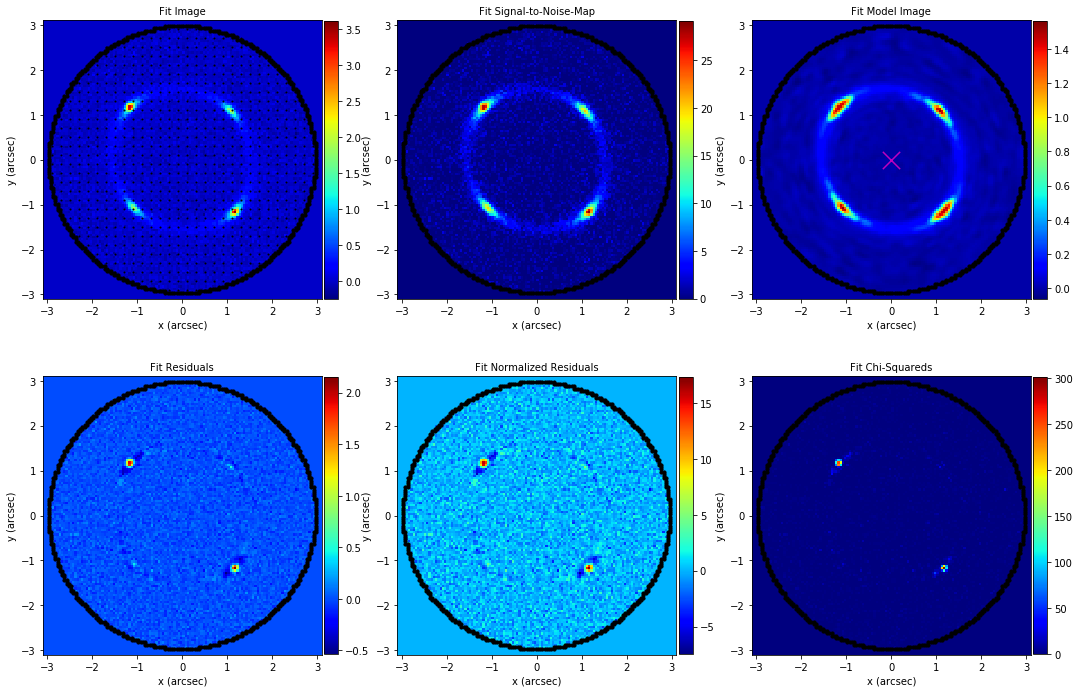

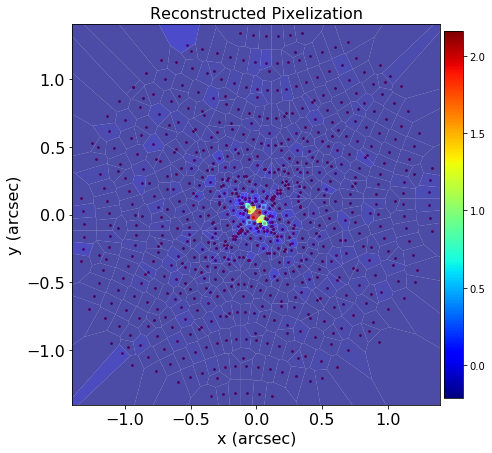

13190.299941056055


In [ ]:
fit_super_compact = fit_ccd_data_with_voronoi_magnification_pixelization(
    ccd_data=ccd_data_source_super_compact, mask=mask, regularization_coefficient=3.1
)

lens_fit_plotters.plot_fit_subplot(
    fit=fit_super_compact,
    should_plot_image_plane_pix=True,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

inversion_plotters.plot_pixelization_values(
    inversion=fit_super_compact.inversion, should_plot_centres=True
)

print(fit_super_compact.evidence)

Okay, so what did we learn? We learnt that, the more compact our source, the worse the fit. This happens despite the fact we are using the *correct* lens mass model, telling us that something is going fundamentally wrong with our source reconstruction and inversion. As you might of guessed, our pixelization is to blame, again!

The problem is the same issue we found when we compared the Rectangular and VoronoiMagnification pixelizations. We are not dedicating enough source-pixels to the central regions of source reconstruction, e.g. where it's brightest. As the source becomes more compact, the source reconstruction doesn't have the resolution to resolve its fine-detailed central structure, causing the fit to the image to degrade.

Think about it - as we made our sources more compact, we go from reconstructing them using ~100 source pixels, to ~20 source pixels to ~ 10 source pixels. This is why we advocated not using the Rectangular pixelization in the previous chapter!

It turns out that adapting to the magnification wasn't really the best idea all along. As we simulated more compact sources the magnification (which is determined via the mass model) didn't change. So, we foolishly reconstructed  each source using fewer and fewer pixels, leading to a worse and worse fit!

Furthermore, when I simulated these source's, I placed them in the highest magnification regions of the source plane! If we moved the source galaxy away from the centre of the caustic, the VoronoiMagnification pixelization would use *even less* pixels to reconstruct it. That is NOT what we want!

So, what do we want? We want a pixelization that congregates pixels in the source's brightest regions, regardless of where it is located in the source-plane. This raises an interesting question; how do we adapt our source pixelization to the reconstructed source, before we've actually reconstructed the source and therefore know what to adapt it too? 

In the next tutorial, I'll explain exactly that. But for now, and to end this tutorial, I'll show you  source-brightness adaption in action, to convince you it works.

The function below fits ccd data using our new VoronoiBrightnessImage pixelization, I'll explain what the hyper_image, weight_floor and weight_power do in the next tutorial.

In [ ]:
def fit_ccd_data_with_voronoi_brightness_pixelization(
    ccd_data, mask, regularization_coefficient, hyper_image, weight_floor, weight_power
):

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.6
        ),
    )

    lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)

    # I explain what these 3 lines are down in a moment!

    source_galaxy = g.Galaxy(
        redshift=1.0,
        pixelization=pix.VoronoiBrightnessImage(
            pixels=500, weight_floor=weight_floor, weight_power=weight_power
        ),
        regularization=reg.Constant(coefficient=regularization_coefficient),
    )

    pixelization_grid = source_galaxy.pixelization.pixelization_grid_from_grid_stack(
        grid_stack=lens_data.grid_stack,
        hyper_image=hyper_image,
        cluster=lens_data.cluster,
    )

    grid_stack_with_pixelization_grid = lens_data.grid_stack.new_grid_stack_with_grids_added(
        pixelization=pixelization_grid
    )

    tracer = ray_tracing.TracerImageSourcePlanes(
        lens_galaxies=[lens_galaxy],
        source_galaxies=[source_galaxy],
        image_plane_grid_stack=grid_stack_with_pixelization_grid,
        border=lens_data.border,
    )

    return lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

I'll explain what a hyper image is in the next tutorial, but given this whole chapter is on 'hyper-fitting', its safe to assume its pretty damn important.

In [ ]:
hyper_image = fit_compact.model_image(return_in_2d=False)

Lets fit the compact ccd_data with a pixelization that adapts to the source's brightness.

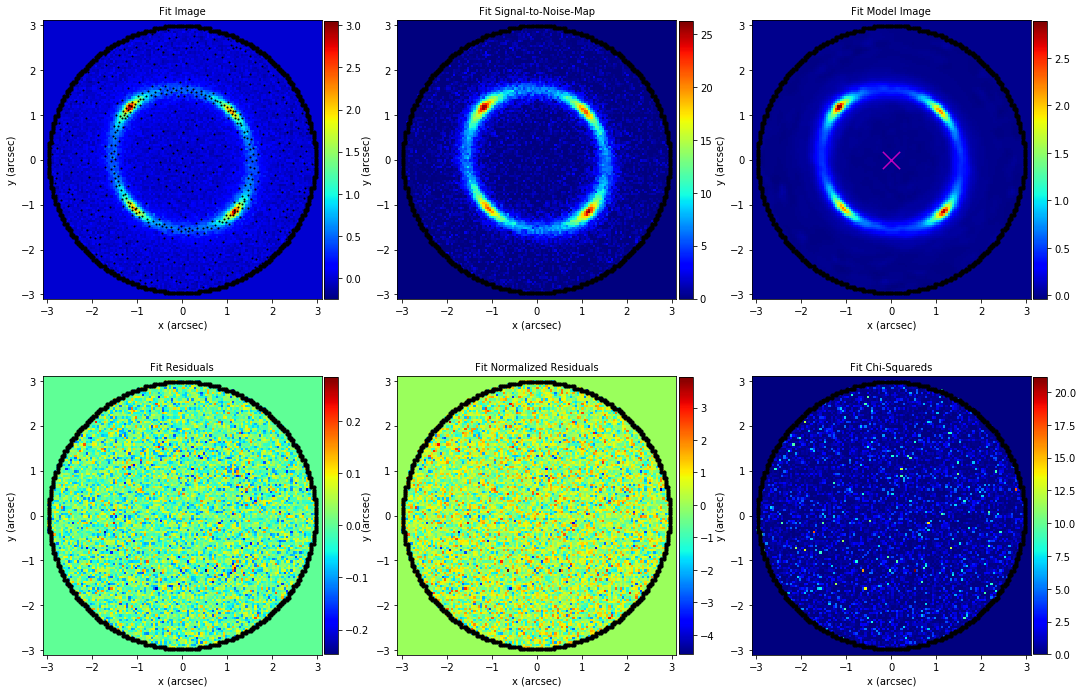

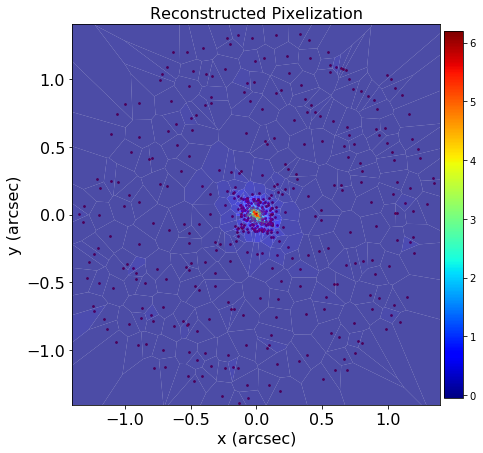

In [ ]:
fit_compact = fit_ccd_data_with_voronoi_brightness_pixelization(
    ccd_data=ccd_data_source_compact,
    mask=mask,
    regularization_coefficient=0.5,
    hyper_image=hyper_image,
    weight_floor=0.0,
    weight_power=10.0,
)

lens_fit_plotters.plot_fit_subplot(
    fit=fit_compact,
    should_plot_image_plane_pix=True,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

inversion_plotters.plot_pixelization_values(
    inversion=fit_compact.inversion, should_plot_centres=True
)

Would you look at that! Our reconstruction of the image no longer has residuals! By congregating more source pixels in the brightest regions of the source reconstruction, we got a better fit. Furthermore, we can check that this indeed corresponds to an increase in Bayesian evidence, noting that the evidence of the compact source when using a VoronoiMagnification pixelization was 14236:

In [ ]:
print("Evidence using magnification based adaptive = ", 14236.292117135737)

print("Evidence using brightness based adaptive = ", fit_compact.evidence)

Evidence using magnification based adaptive =  14236.292117135737
Evidence using brightness based adaptive =  14461.586157385706


It increases! By over 200, which, for a Bayesian evidence, is pretty damn large! Clearly, By any measure, this pixelization is a huge success. It turns out that, all along, we should have been adapting to the source's brightness! In doing so, we will *always* reconstruct the detailed structure of the source's brightest regions with a sufficiently high resolution. Hurrah!

Okay, so we can now adapt our pixelizations to the morphology of our lensed source galaxy. To my knowledge, this is the *best* approach one can take the lens modeling. Its more tricky to implement (as I'll explain in the next tutorial) and introduces a few extra hyper-parameters that we'll need to fit for. But, the pay-off is more than worth it, as we fit our imaging data better and (typically) end up using far fewer source pixels to fit the data, as we don't 'waste' pixels reconstructing regions of the source-plane where there is no signal.